In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('/content/modified_ais_data.csv',nrows=1000)

In [4]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG
0,2022-03-31T00:00:01,671226100,IMO9221322,25.77626,-80.20320,3.2,143.7
1,2022-03-31T00:00:06,367452810,IMO9602344,29.32824,-94.77391,2.6,319.2
2,2022-03-31T00:00:09,366919770,IMO9253583,48.74428,-122.49504,0.0,210.3
3,2022-03-31T00:00:00,311000966,IMO8916607,18.55833,-66.47910,17.5,274.5
4,2022-03-31T00:00:01,219028420,IMO9411305,28.66703,-93.59339,9.5,129.4


In [5]:
import math

def lat_lon_to_cartesian(lat, lon, R=6371):
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    x = R * math.cos(lat_rad) * math.cos(lon_rad)
    y = R * math.cos(lat_rad) * math.sin(lon_rad)
    z = R * math.sin(lat_rad)
    return x, y, z

def cartesian_to_lat_lon(x, y, z, R=6371):
    lon = math.degrees(math.atan2(y, x))
    lat = math.degrees(math.asin(z / R))
    return lat, lon


In [6]:
df[['x', 'y', 'z']] = df.apply(lambda row: pd.Series(lat_lon_to_cartesian(row['LAT'], row['LON'])), axis=1)

In [7]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z
0,2022-03-31T00:00:01,671226100,IMO9221322,25.77626,-80.20320,3.2,143.7,976.189651,-5653.417795,2770.480464
1,2022-03-31T00:00:06,367452810,IMO9602344,29.32824,-94.77391,2.6,319.2,-462.261129,-5535.146877,3120.593645
2,2022-03-31T00:00:09,366919770,IMO9253583,48.74428,-122.49504,0.0,210.3,-2256.980451,-3543.426543,4789.552023
3,2022-03-31T00:00:00,311000966,IMO8916607,18.55833,-66.47910,17.5,274.5,2410.348516,-5537.896973,2027.697745
4,2022-03-31T00:00:01,219028420,IMO9411305,28.66703,-93.59339,9.5,129.4,-350.359001,-5579.067584,3056.287693


In [8]:
import numpy as np
def haversine(lat1, lon1, lat2, lon2, R=6371):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [9]:
df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])

In [10]:
def calculate_distances(group):
    group = group.sort_values(by="BaseDateTime")
    group["next_lat"] = group["LAT"].shift(-1)
    group["next_long"] = group["LON"].shift(-1)
    group["distance_km"] = group.apply(
        lambda row: haversine(row["LAT"], row["LON"], row["next_lat"], row["next_long"])
        if not np.isnan(row["next_lat"])
        else 0,
        axis=1,
    )
    return group.drop(columns=["next_lat", "next_long"])

In [11]:
df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)
df.head()

<ipython-input-11-e18fd20cbb70>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km
0,2022-03-31 00:00:17,1056261,IMO1056261,26.11809,-80.14815,0.1,220.5,978.775466,-5636.091653,2804.658708,0.000000
1,2022-03-31 00:01:13,209136000,IMO9416707,45.64101,-122.74869,0.0,218.5,-2409.574733,-3746.291746,4555.094813,0.000000
2,2022-03-31 00:00:01,209513000,IMO9060247,26.09387,-80.08081,28.3,272.6,985.603053,-5636.104757,2802.240317,0.563219
3,2022-03-31 00:01:03,209513000,IMO9060247,26.09386,-80.08645,14.9,269.4,985.048333,-5636.202230,2802.239319,0.000000
4,2022-03-31 00:00:00,209613000,IMO9266542,29.80067,-79.81317,10.6,186.0,977.761677,-5441.347041,3166.285755,0.000000


In [12]:
def calculate_durations(group):
    # Ensure BaseDateTime is a datetime type
    group['BaseDateTime'] = pd.to_datetime(group['BaseDateTime'])
    # Calculate the duration between consecutive points in seconds
    group['duration_seconds'] = group['BaseDateTime'].diff().dt.total_seconds()
    return group

In [13]:
df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)
df = df.reset_index(drop=True)
df.head()

<ipython-input-13-1fbd24d56e1c>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km,duration_seconds
0,2022-03-31 00:00:17,1056261,IMO1056261,26.11809,-80.14815,0.1,220.5,978.775466,-5636.091653,2804.658708,0.000000,NaN
1,2022-03-31 00:01:13,209136000,IMO9416707,45.64101,-122.74869,0.0,218.5,-2409.574733,-3746.291746,4555.094813,0.000000,NaN
2,2022-03-31 00:00:01,209513000,IMO9060247,26.09387,-80.08081,28.3,272.6,985.603053,-5636.104757,2802.240317,0.563219,NaN
3,2022-03-31 00:01:03,209513000,IMO9060247,26.09386,-80.08645,14.9,269.4,985.048333,-5636.202230,2802.239319,0.000000,62.0
4,2022-03-31 00:00:00,209613000,IMO9266542,29.80067,-79.81317,10.6,186.0,977.761677,-5441.347041,3166.285755,0.000000,NaN


In [14]:
# Define constants
KNOTS_TO_METERS_PER_SEC = 0.514444
df['sog_mps'] = df['SOG'].apply(lambda x: x * KNOTS_TO_METERS_PER_SEC)
df['cog_radians'] = df['COG'].apply(lambda x: np.radians(x))


In [15]:
df = df[['x','y','z','duration_seconds','distance_km','sog_mps','cog_radians']]

In [16]:
df.head()

,x,y,z,duration_seconds,distance_km,sog_mps,cog_radians
0,978.775466,-5636.091653,2804.658708,NaN,0.000000,0.051444,3.848451
1,-2409.574733,-3746.291746,4555.094813,NaN,0.000000,0.000000,3.813544
2,985.603053,-5636.104757,2802.240317,NaN,0.563219,14.558765,4.757768
3,985.048333,-5636.202230,2802.239319,62.0,0.000000,7.665216,4.701917
4,977.761677,-5441.347041,3166.285755,NaN,0.000000,5.453106,3.246312


In [17]:
df.dropna(inplace=True)

In [18]:
df.head()

,x,y,z,duration_seconds,distance_km,sog_mps,cog_radians
3,985.048333,-5636.202230,2802.239319,62.0,0.0,7.665216,4.701917
8,1038.813807,-5617.560112,2820.199507,66.0,0.0,7.459438,0.713840
28,964.816679,-5298.686551,3403.335218,69.0,0.0,5.813217,4.066617
32,945.221036,-5275.068348,3445.265174,69.0,0.0,6.173328,2.089159
48,1043.049048,-5653.562549,2745.709415,61.0,0.0,6.276217,3.267256


# attention (en+de)

In [1]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import (
#     Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, TimeDistributed, Lambda
# )
# from tensorflow.keras.optimizers import Adam
# from sklearn.preprocessing import MinMaxScaler


# # Split data to prevent leakage
# train_size = int(len(df) * 0.8)
# train_data = df.iloc[:train_size]
# test_data = df.iloc[train_size:]

# # Scale separately to avoid data leakage
# scaler = MinMaxScaler()
# scaled_train = scaler.fit_transform(train_data)
# scaled_test = scaler.transform(test_data)

# # Function to create sequences with step size = seq_length
# def create_sequences(data, seq_length):
#     X, decoder_inputs, decoder_targets = [], [], []

#     for i in range(0, len(data) - seq_length, seq_length):  # Step size = seq_length
#         X.append(data[i:i+seq_length])  # Encoder input: Full sequence

#         # Decoder input: Start token + shifted sequence
#         start_token = np.zeros((1, data.shape[1]))  # Start token (1 row of zeros)
#         decoder_in = np.vstack([start_token, data[i+1:i+seq_length]])

#         # Decoder target: Shifted sequence
#         decoder_target = data[i+1:i+seq_length+1]

#         decoder_inputs.append(decoder_in)
#         decoder_targets.append(decoder_target)

#     return np.array(X), np.array(decoder_inputs), np.array(decoder_targets)

# seq_length = 10  # Look at last 10 time steps
# X_train, decoder_inputs_train, decoder_targets_train = create_sequences(scaled_train, seq_length)
# X_test, decoder_inputs_test, decoder_targets_test = create_sequences(scaled_test, seq_length)

# # Transformer Encoder Block
# def transformer_encoder(inputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
#     input_dim = tf.keras.backend.int_shape(inputs)[-1]
#     key_dim = max(1, input_dim // num_heads)

#     attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
#     attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(attention_norm, attention_norm)
#     attention = Dropout(dropout_rate)(attention)
#     attention = inputs + attention
#     attention = LayerNormalization(epsilon=1e-6)(attention)

#     ff_output = Dense(ff_dim, activation="relu")(attention)
#     ff_output = Dense(input_dim)(ff_output)
#     ff_output = Dropout(dropout_rate)(ff_output)

#     return LayerNormalization(epsilon=1e-6)(attention + ff_output)

# # Transformer Decoder Block with Causal Mask
# def transformer_decoder(inputs, encoder_outputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
#     input_dim = tf.keras.backend.int_shape(inputs)[-1]
#     key_dim = max(1, input_dim // num_heads)

#     # Define causal mask using Lambda layer
#     def create_causal_mask(seq_len):
#         mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)  # Lower triangular mask
#         return 1 - mask  # Invert: 1 where to mask, 0 where allowed

#     causal_mask = Lambda(lambda x: create_causal_mask(tf.shape(x)[1]))(inputs)

#     attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
#     attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
#         attention_norm, attention_norm, attention_mask=causal_mask
#     )
#     attention1 = Dropout(dropout_rate)(attention1)
#     attention1 = inputs + attention1
#     attention1 = LayerNormalization(epsilon=1e-6)(attention1)

#     attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
#         query=attention1, key=encoder_outputs, value=encoder_outputs
#     )
#     attention2 = Dropout(dropout_rate)(attention2)
#     attention2 = attention1 + attention2
#     attention2 = LayerNormalization(epsilon=1e-6)(attention2)

#     ff_output = Dense(ff_dim, activation="relu")(attention2)
#     ff_output = Dense(input_dim)(ff_output)
#     ff_output = Dropout(dropout_rate)(ff_output)

#     return LayerNormalization(epsilon=1e-6)(attention2 + ff_output)

# # Build Transformer Model
# def build_transformer_model(input_shape, target_shape, num_heads=4, ff_dim=64):
#     encoder_inputs = Input(shape=input_shape, name="encoder_inputs")
#     encoder_outputs = transformer_encoder(encoder_inputs, num_heads, ff_dim)
#     encoder_outputs = transformer_encoder(encoder_outputs, num_heads, ff_dim)

#     decoder_inputs = Input(shape=target_shape, name="decoder_inputs")
#     decoder_outputs = transformer_decoder(decoder_inputs, encoder_outputs, num_heads, ff_dim)
#     decoder_outputs = transformer_decoder(decoder_outputs, encoder_outputs, num_heads, ff_dim)

#     # Preserve Temporal Structure with TimeDistributed
#     x = TimeDistributed(Dense(32, activation="relu"))(decoder_outputs)
#     outputs = TimeDistributed(Dense(target_shape[-1]))(x)  # Output per time step

#     model = Model([encoder_inputs, decoder_inputs], outputs)
#     return model

# # Define target shape correctly
# target_shape = (seq_length, X_train.shape[-1])  # Adjusted to match correct sequence length

# # Build model
# model = build_transformer_model((seq_length, X_train.shape[2]), target_shape, num_heads=4, ff_dim=64)

# # Compile Model
# model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])

# # Train Model
# history = model.fit(
#     [X_train, decoder_inputs_train], decoder_targets_train,
#     epochs=50, batch_size=16,
#     validation_data=([X_test, decoder_inputs_test], decoder_targets_test)
# )

# # Plot Training History
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.legend()
# plt.title("Training Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.show()


In [30]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, MultiHeadAttention, LayerNormalization, Dropout,
    TimeDistributed, Lambda, Embedding
)
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Data Preprocessing
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# Scale data separately to prevent leakage
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

# Pad features to make even
if scaled_train.shape[1] % 2 != 0:
    scaled_train = np.hstack([scaled_train, np.zeros((scaled_train.shape[0], 1))])
    scaled_test = np.hstack([scaled_test, np.zeros((scaled_test.shape[0], 1))])

# Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        _, seq_len, d_model = input_shape

        if d_model % 2 != 0:  # Ensure even d_model
            raise ValueError(f"d_model must be even, but got {d_model}")

        pos = np.arange(seq_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))

        pe = np.zeros((seq_len, d_model))
        pe[:, 0::2] = np.sin(pos * div_term)
        pe[:, 1::2] = np.cos(pos * div_term)
        self.pe = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pe[:, :tf.shape(inputs)[1], :]

# Learned Start Token
start_token_layer = Embedding(input_dim=1, output_dim=df.shape[1])

def create_sequences(data, seq_length):
    X, decoder_inputs, decoder_targets = [], [], []

    for i in range(len(data) - seq_length - 1):
        X.append(data[i:i+seq_length])

        # Ensure start token matches feature dimension
        start_token = start_token_layer(tf.zeros((1, 1), dtype=tf.int32)).numpy()[0]

        # Adjust dimensions if needed
        if start_token.shape[0] != data.shape[1]:
            start_token = np.zeros((data.shape[1],))  # Ensure same shape

        decoder_in = np.vstack([start_token, data[i+1:i+seq_length]])

        # Decoder target
        decoder_target = data[i+1:i+seq_length+1]

        decoder_inputs.append(decoder_in)
        decoder_targets.append(decoder_target)

    return np.array(X), np.array(decoder_inputs), np.array(decoder_targets)

seq_length = 10  # Fixed step size
X_train, decoder_inputs_train, decoder_targets_train = create_sequences(scaled_train, seq_length)
X_test, decoder_inputs_test, decoder_targets_test = create_sequences(scaled_test, seq_length)

# Ensure feature_dim is even
# Remove these lines:
feature_dim = X_train.shape[2]
if feature_dim % 2 != 0:
    feature_dim += 1

# Transformer Encoder Block
def transformer_encoder(inputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
    input_dim = tf.keras.backend.int_shape(inputs)[-1]
    key_dim = max(1, input_dim // num_heads)

    attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(attention_norm, attention_norm)
    attention = Dropout(dropout_rate)(attention)
    attention = inputs + attention
    attention = LayerNormalization(epsilon=1e-6)(attention)

    ff_output = Dense(ff_dim, activation="relu")(attention)
    ff_output = Dense(input_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)

    return LayerNormalization(epsilon=1e-6)(attention + ff_output)

# Transformer Decoder Block with Corrected Causal Mask
def create_causal_mask(seq_len):
    mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    mask = tf.where(mask == 0, -np.inf, 0)
    return mask

def transformer_decoder(inputs, encoder_outputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
    input_dim = tf.keras.backend.int_shape(inputs)[-1]
    key_dim = max(1, input_dim // num_heads)

    causal_mask = Lambda(lambda x: create_causal_mask(tf.shape(x)[1]))(inputs)

    attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
    attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
        attention_norm, attention_norm, attention_mask=causal_mask
    )
    attention1 = Dropout(dropout_rate)(attention1)
    attention1 = inputs + attention1
    attention1 = LayerNormalization(epsilon=1e-6)(attention1)

    attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
        query=attention1, key=encoder_outputs, value=encoder_outputs
    )
    attention2 = Dropout(dropout_rate)(attention2)
    attention2 = attention1 + attention2
    attention2 = LayerNormalization(epsilon=1e-6)(attention2)

    ff_output = Dense(ff_dim, activation="relu")(attention2)
    ff_output = Dense(input_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)

    return LayerNormalization(epsilon=1e-6)(attention2 + ff_output)

# Build Transformer Model
def build_transformer_model(input_shape, target_shape, num_heads=4, ff_dim=64):
    encoder_inputs = Input(shape=input_shape, name="encoder_inputs")
    x = PositionalEncoding()(encoder_inputs)  # Add positional encoding
    encoder_outputs = transformer_encoder(x, num_heads, ff_dim)
    encoder_outputs = transformer_encoder(encoder_outputs, num_heads, ff_dim)

    decoder_inputs = Input(shape=target_shape, name="decoder_inputs")
    x = PositionalEncoding()(decoder_inputs)  # Add positional encoding
    decoder_outputs = transformer_decoder(x, encoder_outputs, num_heads, ff_dim)
    decoder_outputs = transformer_decoder(decoder_outputs, encoder_outputs, num_heads, ff_dim)

    x = TimeDistributed(Dense(32, activation="relu"))(decoder_outputs)
    outputs = TimeDistributed(Dense(target_shape[-1]))(x)

    return Model([encoder_inputs, decoder_inputs], outputs)

# Define target shape correctly
target_shape = (seq_length, X_train.shape[-1])


# Train Model
# Build model with corrected dimensions
model = build_transformer_model(
    (seq_length, scaled_train.shape[1]),  # Now has even features
    (seq_length, scaled_train.shape[1]),   # Same for decoder
    num_heads=4,
    ff_dim=64
)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError(),'accuracy']
)

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, 10, 6)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_encoding_15    │ (None, 10, 6)          │              0 │ encoder_inputs[0][0]   │
│ (PositionalEncoding)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_74    │ (None, 10, 6)          │             12 │ positional_encoding_1… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_30   │ (None, 10, 6)          │            114 │ layer_normalization_7… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_83 (Dropout)      │ (None, 10, 6)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_52 (Add)              │ (None, 10, 6)          │              0 │ positional_encoding_1… │
│                           │                        │                │ dropout_83[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_75    │ (None, 10, 6)          │             12 │ add_52[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_52 (Dense)          │ (None, 10, 64)         │            448 │ layer_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_53 (Dense)          │ (None, 10, 6)          │            390 │ dense_52[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_84 (Dropout)      │ (None, 10, 6)          │              0 │ dense_53[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_53 (Add)              │ (None, 10, 6)          │              0 │ layer_normalization_7… │
│                           │                        │                │ dropout_84[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_76    │ (None, 10, 6)          │             12 │ add_53[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_77    │ (None, 10, 6)          │             12 │ layer_normalization_7… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_31   │ (None, 10, 6)          │            114 │ layer_normalization_7… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_86 (Dropout) 

 Total params: 4,626 (18.07 KB)

 Trainable params: 4,626 (18.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.1804 - loss: 0.3504 - mean_absolute_error: 0.4888 - val_accuracy: 0.2032 - val_loss: 0.1173 - val_mean_absolute_error: 0.2826
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2060 - loss: 0.1056 - mean_absolute_error: 0.2636 - val_accuracy: 0.2190 - val_loss: 0.0821 - val_mean_absolute_error: 0.2310
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2103 - loss: 0.0800 - mean_absolute_error: 0.2281 - val_accuracy: 0.2138 - val_loss: 0.0722 - val_mean_absolute_error: 0.2159
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1997 - loss: 0.0744 - mean_absolute_error: 0.2198 - val_accuracy: 0.2159 - val_loss: 0.0705 - val_mean_absolute_error: 0.2130
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2293 - loss: 0.0731 - mean_absolute_error: 0.2174 - val_accuracy: 0.1989 - val_loss: 0.0699 - val_mean_absolute_error: 0.2116
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31m

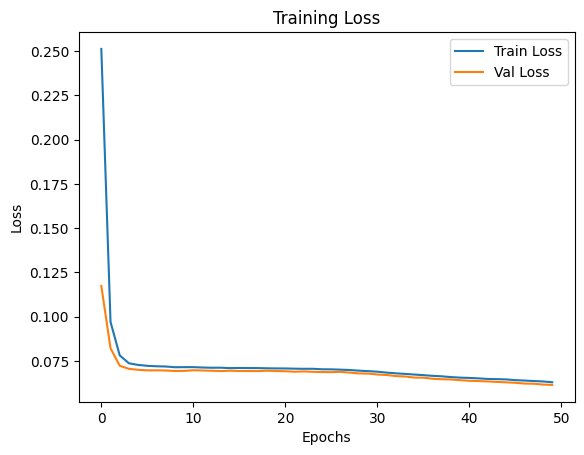

In [31]:
# Train Model
history = model.fit(
    [X_train, decoder_inputs_train], decoder_targets_train,
    epochs=50, batch_size=32,
    validation_data=([X_test, decoder_inputs_test], decoder_targets_test)
)

# Plot Training History
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()